## preparation

In [13]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [14]:
import os #untuk mengolah file2 (mirip kayak cmd di terminal)
import cv2 #untuk mengolah image nya
import numpy as np #untuk perhitungan matematika
import matplotlib.pyplot as plt #untuk visualisasi

In [16]:
def load_image(image_path):
  image = cv2.imread(image_path) #load image RGB
  if image is None:
    print('Error: Could not load image.')
    return None, None
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #dalam skala grayscale #convert dari BGR ke gray
  return image, gray

#ndarray array dari numpy


In [17]:
sample_image, sample_image_gray = load_image('images/George_W_Bush/1.jpg')

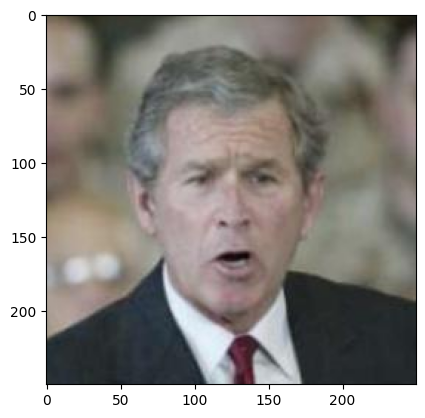

In [18]:
# menampilkan wajahnya
sampleImg_RGB = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sampleImg_RGB)

#kenapa biru? karena skala warna di opencv itu bukan RGB tapi BGR

In [33]:
# Load semua dataset
dataset_dir = 'images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _, image_gray = load_image(os.path.join(root, f))
    if image_gray is None:
      continue
    images.append(image_gray)
    labels.append(root.split('/')[-1]) #extract semua string dataset

In [34]:
len(labels)

79

## Face Detection

In [35]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#model haar cascade untuk menentukan lokasi wajah -> pake konsep konvolusi
#parameter deteksi wajah :
#scalefactor, minNeighbors, minsize

In [36]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
  faces = face_cascade.detectMultiScale(
    image_gray,
    scaleFactor=scale_factor,
    minNeighbors=min_neighbors,
    minSize=min_size
  )
  return faces

In [37]:
sample_faces = detect_faces(sample_image_gray, min_size=(50, 50)) # klo ini brrti mau ubah minsize

#hasil matriksnya itu [x, y, w, h]
# x sama y itu titik koordinat plg pojok kiri atas, w = panjang, h = lebar

In [38]:
def crop_faces(image_gray, faces, return_all=False):
  cropped_faces = []
  selected_faces = []
  if len(faces) > 0:
    if return_all:
      for x, y, w, h in faces:
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    else:
      x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
      selected_faces.append((x, y, w, h))
      cropped_faces.append(image_gray[y:y+h, x:x+w])
  return cropped_faces, selected_faces

In [39]:
cropped_faces, _ = crop_faces(sample_image_gray, sample_faces)

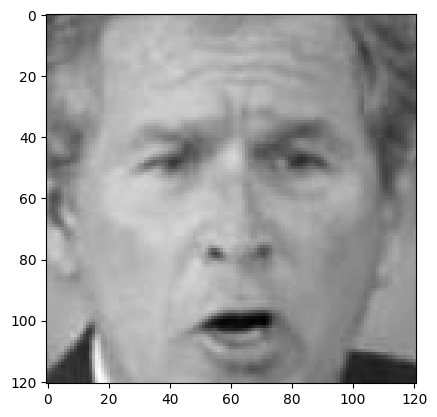

In [40]:
plt.imshow(cropped_faces[0], cmap='gray')

## Face Recognition - Eigenface

In [41]:
#menyamakan ukuran wajah
# untuk eigenface preprocessingnya ada dua yaitu : resize dan flattened
face_size = (128, 128)

def resize_and_flatten(face):
  face_resized = cv2.resize(face, face_size)
  face_flattened = face_resized.flatten() #flattened itu klo misal si array 2 dimensi, maka dijadiin 1 dimensi
  return face_flattened

In [42]:
X = [] #data yang akan diolah
y = [] #label

for image, label in zip(images, labels):
  faces = detect_faces(image)
  cropped_faces, _ = crop_faces(image, faces)
  if len(cropped_faces) > 0:
    face_flattened = resize_and_flatten(cropped_faces[0])
    X.append(face_flattened)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [43]:
X.shape

(75, 16384)

In [44]:
#pisahin data latih dan testing (30%testing 70% training)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=177, stratify=y)

In [45]:
#mean centering = data dikurangi dengan rata2

from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.mean_face = np.mean(X, axis=0)
    return self
  def transform(self, X):
    return X - self.mean_face

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([
  ('centering', MeanCentering()),
  ('pca', PCA(svd_solver='randomized', whiten=True,random_state=177)),
  ('svc', SVC(kernel='linear', random_state=177))
])

In [47]:
#Train and Evaluate

from sklearn.metrics import classification_report

pipe.fit(X_train, y_train) #fit dipanggil untuk training

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

           images\Ariel_Sharon       0.75      0.75      0.75         4
          images\George_W_Bush       1.00      0.67      0.80         3
images\Gloria_Macapagal_Arroyo       1.00      1.00      1.00         4
             images\Laura_Bush       1.00      1.00      1.00         3
          images\Nasya_Raudhah       0.60      1.00      0.75         3
        images\Serena_Williams       1.00      1.00      1.00         3
         images\Vladimir_Putin       0.50      0.33      0.40         3

                      accuracy                           0.83        23
                     macro avg       0.84      0.82      0.81        23
                  weighted avg       0.84      0.83      0.82        23



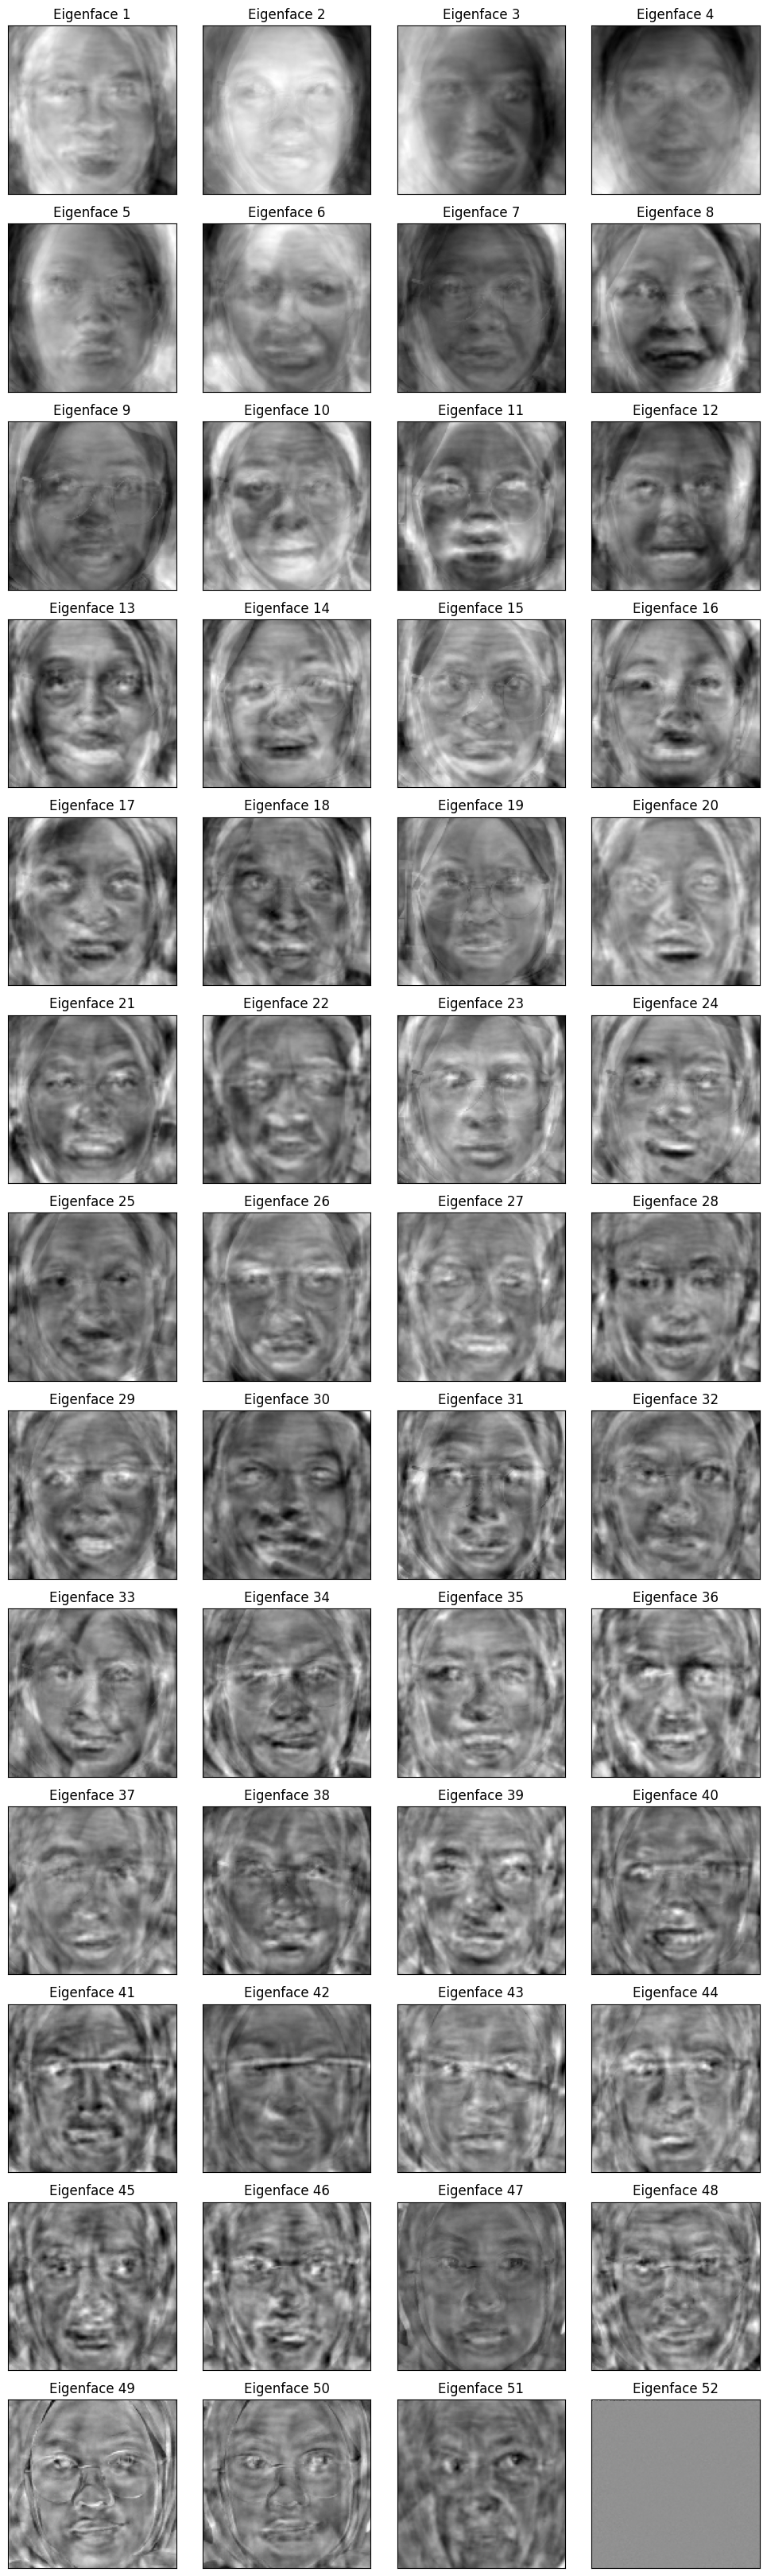

In [48]:
n_components = len(pipe[1].components_)

ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),
subplot_kw={'xticks':[], 'yticks':[]})

eigenfaces = pipe[1].components_.reshape((n_components,
X_train.shape[1]))
for i, ax in enumerate(axes.flat[:n_components]):
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()
plt.show()

In [49]:
import pickle

#untuk download modelnya
with open('eigenface_pipeline.pkl', 'wb') as f:
  pickle.dump(pipe, f)

In [50]:
def get_eigenface_score(X):
  X_pca = pipe[:2].transform(X)
  eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
  return eigenface_scores

In [51]:
def eigenface_prediction(image_gray):
  faces = detect_faces(image_gray)
  cropped_faces, selected_faces = crop_faces(image_gray, faces)

  if len(cropped_faces) == 0:
    return 'No face detected.'
  X_face = []
  for face in cropped_faces:
    face_flattened = resize_and_flatten(face)
    X_face.append(face_flattened)

    X_face = np.array(X_face)
    labels = pipe.predict(X_face)
    scores = get_eigenface_score(X_face)

    return scores, labels, selected_faces

In [52]:
sample_scores, sample_labels, sample_faces = eigenface_prediction(sample_image_gray)

In [53]:
sample_scores

array([6.28571561])

In [54]:
sample_labels

array(['images\\George_W_Bush'], dtype='<U30')

In [55]:
def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale=0.6,
              font_thickness=2,
              text_color=(0, 0, 0),
              text_color_bg=(0, 255, 0)
              ):

  x, y = pos
  score_text = f'Score: {score:.2f}'
  (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale,
                                font_thickness)
  (w2, h2), _ = cv2.getTextSize(label, font, font_scale,
                                font_thickness)
  cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y),
                text_color_bg, -1)
  cv2.putText(image, label, (x+10, y-10), font, font_scale,
              text_color, font_thickness)
  cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale,
              text_color, font_thickness)

In [56]:
def draw_result(image, scores, labels, coords):
  result_image = image.copy()
  for (x, y, w, h), label, score in zip(coords, labels, scores):
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0),
2)
    draw_text(result_image, label, score, pos=(x, y))
  return result_image

In [57]:
result_image = draw_result(sample_image, sample_scores, sample_labels, sample_faces)

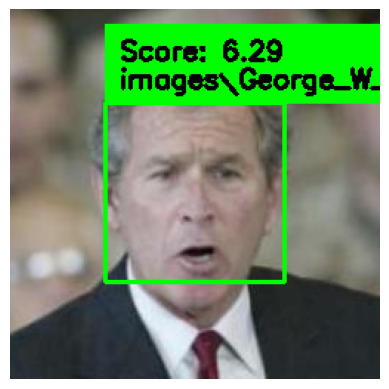

In [58]:
import cv2
from matplotlib import pyplot as plt

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [59]:
import pickle
with open("eigenface_pipeline.pkl", "rb") as f:
    pipeline = pickle.load(f)


In [60]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class MeanCentering(BaseEstimator, TransformerMixin):
    def __init__(self, mean_face):
        self.mean_face = mean_face

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X shape (n_samples, n_features)
        return X - self.mean_face


In [61]:
import cv2
import numpy as np
import pickle

# Load pipeline model
with open("eigenface_pipeline.pkl", "rb") as f:
    pipeline = pickle.load(f)

# Ambil dimensi training dari PCA
pca = pipeline.named_steps["pca"]
img_dim = int(np.sqrt(pca.mean_.shape[0]))

# Load Haar Cascade
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # —————————————————————————————
    # Mirror / flip frame secara horizontal
    frame = cv2.flip(frame, 1)
    # —————————————————————————————

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = gray[y : y + h, x : x + w]
        face_resized = cv2.resize(face_roi, (img_dim, img_dim))

        feat = face_resized.flatten().reshape(1, -1)
        label = pipeline.predict(feat)[0]

        # ambil confidence
        conf = None
        if hasattr(pipeline, "decision_function"):
            raw = pipeline.decision_function(feat)
            conf = float(np.max(raw)) if isinstance(raw, np.ndarray) else float(raw)
        elif hasattr(pipeline, "predict_proba"):
            proba = pipeline.predict_proba(feat)[0]
            conf = float(np.max(proba))

        # gambar kotak & teks
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = f"ID: {label}"
        if conf is not None:
            text += f", Conf: {conf:.2f}"
        cv2.putText(frame, text, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2.imshow("Eigenface Pipeline Webcam (Mirrored)", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
